In [1]:
!pip install mediapipe opencv-python scikit-learn imbalanced-learn pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

2024-06-27 11:21:30.166157: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 11:21:30.197759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 11:21:30.729061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
## Testando caminho

(-0.5, 47.5, 47.5, -0.5)

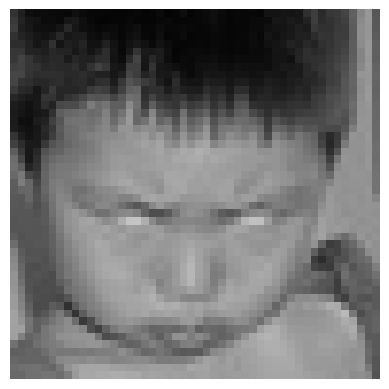

In [4]:
img = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_10118481.jpg')
plt.imshow(img,'binary')
plt.axis(False)

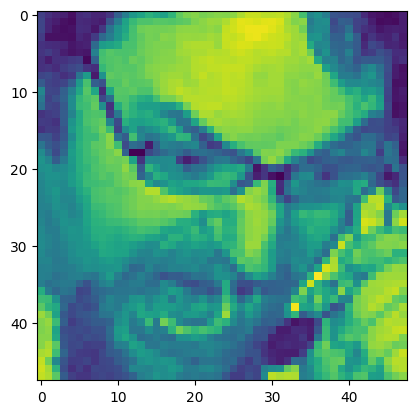

In [5]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/angry/PrivateTest_10131363.jpg', 0)
plt.imshow(image)

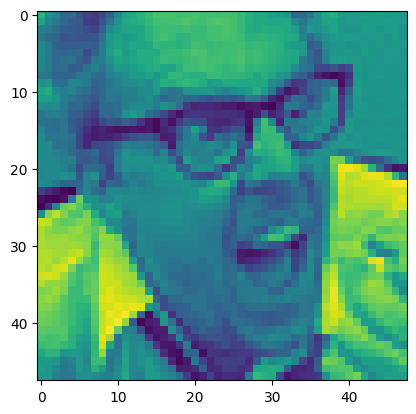

In [6]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_3908.jpg', 0)
plt.imshow(image)

In [66]:
## Antes de remover as imagens

In [67]:
for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive
There are 7 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train
There are 0 directories and 384 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust
There are 0 directories and 4852 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/neutral
There are 0 directories and 3763 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/fear
There are 0 directories and 4444 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/sad
There are 0 directories and 3654 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry
There are 0 directories and 7005 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/happy
There are 0 directories 

In [7]:
## Remover imagens que não são rostos

In [8]:
face_detector = mp.solutions.face_detection.FaceDetection()
data_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection'

for dataset in ['train', 'test']:
    dataset_dir = os.path.join(data_dir, 'archive', dataset)
    for emotion_dir in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion_dir)
        if os.path.isdir(emotion_path):
            image_paths = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path)]
            for image_path in image_paths:
                image = cv2.imread(image_path)
                results = face_detector.process(image)
                if not results.detections:
                    os.remove(image_path)
                    print(f"Removida imagem incorreta: {image_path}")

for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

I0000 00:00:1719404171.817656   57655 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719404171.834718   57763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1719404171.836789   57749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust/Training_60245347.jpg
Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust/Training_76503162.jpg
Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust/Training_47680332.jpg
Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust/Training_65372676.jpg
Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust/Training_31108028.jpg
Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust/Training_63156802.jpg
Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust/Training_59222915.jpg
Removida imagem incorreta: /home/viniciuss/Documents/projetos/FER-201

In [7]:
## Iniciando

In [7]:
# Pontos da face
face_landmarks = [
    *mp.solutions.face_mesh.FACEMESH_LIPS,
    *mp.solutions.face_mesh.FACEMESH_LEFT_EYE,
    *mp.solutions.face_mesh.FACEMESH_LEFT_IRIS,
    *mp.solutions.face_mesh.FACEMESH_LEFT_EYEBROW,
    *mp.solutions.face_mesh.FACEMESH_RIGHT_EYE,
    *mp.solutions.face_mesh.FACEMESH_RIGHT_IRIS,
    *mp.solutions.face_mesh.FACEMESH_RIGHT_EYEBROW,
    (21, 54), (103, 67), (109, 10), (338, 297), (332, 284), (251, 71), (68, 104), (69, 108), (151, 337), (299, 333), (298, 301), (9, 143), (111, 117), (118, 119), (120, 121), (128, 245), (214, 207), (205, 36), (142, 126), (217, 174), (372, 340), (346, 347), (348, 349), (350, 357), (465, 434), (427, 425), (266, 371), (355, 437), (399, 0)
]

# Caminho para o diretório
data_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/'
train_dir = os.path.join(data_dir, 'archive', 'train')
test_dir = os.path.join(data_dir, 'archive', 'test')

# Lista para armazenar os caminhos e emoções
list_imgs = []

# Iterar sobre todas as classes no diretório de treinamento
for dataset in ['train', 'test']:
    dataset_dir = os.path.join(data_dir, 'archive', dataset)
    for emotion_dir in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion_dir)
        if os.path.isdir(emotion_path):
            for img in os.listdir(emotion_path):
                list_imgs.append([dataset + "/" + emotion_dir + "/" + img, emotion_dir])

In [8]:
# DataFrame com os caminhos dos arquivos e emoções
df = pd.DataFrame(list_imgs, columns=['Filepath', 'emotion'])
df.head()

,Filepath,emotion
0,train/disgust/Training_73989844.jpg,disgust
1,train/disgust/Training_71591976.jpg,disgust
2,train/disgust/Training_77025552.jpg,disgust
3,train/disgust/Training_14124662.jpg,disgust
4,train/disgust/Training_98334760.jpg,disgust


In [9]:
# Verificar classes únicas e contagens
unique_classes, class_counts = df['emotion'].value_counts().index, df['emotion'].value_counts().values
print("Classes únicas:", unique_classes)
print("Contagem de amostras por classe:", class_counts)

#face_detector = mp.solutions.face_detection.FaceDetection()

Classes únicas: Index(['happy', 'neutral', 'sad', 'fear', 'angry', 'surprise', 'disgust'], dtype='object', name='emotion')
Contagem de amostras por classe: [8733 6053 5581 4724 4529 3833  482]


In [10]:
def convert_dict_to_arrays(data_dict):
    data = []
    labels = []
    for img_path, landmarks in data_dict.items():
        data.append(np.array(landmarks).flatten())
        labels.append(img_path.split("/")[-2])
    return np.asarray(data), np.asarray(labels)

def split_data(data, labels, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, shuffle=True, stratify=labels)
    return x_train, x_test, y_train, y_test

In [13]:
def gather_landmark_data(train_dir, test_dir):
    mp_face_mesh = mp.solutions.face_mesh
    mp_drawing = mp.solutions.drawing_utils
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
    
    train_landmarks = []
    test_landmarks = []
    
    # Extrair landmarks do conjunto de treinamento
    for filename in os.listdir(train_dir):
        img_path = os.path.join(train_dir, filename)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img_rgb)
        
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            landmark_coords = np.array([landmarks.landmark[i] for i in face_landmarks])
            train_landmarks.append(landmark_coords.flatten())
        else:
            print(f"No face detected in {img_path}. Skipping...")
    
    # Extrair landmarks do conjunto de teste
    for filename in os.listdir(test_dir):
        img_path = os.path.join(test_dir, filename)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img_rgb)
        
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            landmark_coords = np.array([landmarks.landmark[i] for i in face_landmarks])
            test_landmarks.append(landmark_coords.flatten())
        else:
            print(f"No face detected in {img_path}. Skipping...")
    
    face_mesh.close()
    
    # Salvar os landmarks em arquivos Parquet
    train_landmarks_df = pd.DataFrame(train_landmarks)
    train_landmarks_df.to_parquet('./train_landmarks.parquet')
    
    test_landmarks_df = pd.DataFrame(test_landmarks)
    test_landmarks_df.to_parquet('./test_landmarks.parquet')
    
    return train_landmarks_df, test_landmarks_df

In [12]:
# Carregar os landmarks do conjunto de treinamento
train_landmarks_df = pd.read_parquet('train_landmarks.parquet')
X_train = train_landmarks_df.values
y_train = train_landmarks_df['emotion'].values

# Carregar os landmarks do conjunto de teste
test_landmarks_df = pd.read_parquet('test_landmarks.parquet')
X_test = test_landmarks_df.values
y_test = test_landmarks_df['emotion'].values

# Dividir o conjunto de treinamento em 80% treino e 20% validação
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'train_landmarks.parquet'

In [13]:
# Treinar o modelo SVC (gamma, c, kernel)

In [39]:
# Carregar os dados de treinamento e teste
#X_train, y_train = load_train_data()
#X_test, y_test = load_test_data()

# Codificar os rótulos de texto em valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definir o intervalo de valores para os hiperparâmetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Criar o modelo SVC
svc = SVC()

# Realizar a busca em grade
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinar o modelo SVC com os rótulos codificados
svc = SVC(C=1, gamma=0.01, kernel='rbf')
svc.fit(X_train, y_train_encoded)

# Avaliar o modelo no conjunto de teste
accuracy = svc.score(X_test, y_test_encoded)
print("Acurácia no conjunto de teste:", accuracy)

ValueError: y contains previously unseen labels: None

In [36]:
# Carregar os landmarks do conjunto de treinamento
train_landmarks_df = pd.read_parquet('train_landmarks.parquet')

print('Primeiras linhas do DataFrame')
print(train_landmarks_df.head())

print('\nTamanho do DataFrame')
print(train_landmarks_df.shape)

print('\nVerificar se há valores ausentes')
print(train_landmarks_df.isnull().sum())

example_landmarks = train_landmarks_df.iloc[0, :-1].values

print('\nVerificar o intervalo dos valores de landmarks faciais')
print(f"Valores mínimos: {example_landmarks.min()}")
print(f"Valores máximos: {example_landmarks.max()}")

Primeiras linhas do DataFrame
      0  emotion
0  None  disgust
1  None  disgust
2  None  disgust
3  None  disgust
4  None  disgust

Tamanho do DataFrame
(27145, 2)

Verificar se há valores ausentes
0          27145
emotion        0
dtype: int64

Verificar o intervalo dos valores de landmarks faciais
Valores mínimos: None
Valores máximos: None


In [37]:
# Carregar os landmarks do conjunto de teste
train_landmarks_df = pd.read_parquet('test_landmarks.parquet')

print('Primeiras linhas do DataFrame')
print(test_landmarks_df.head())

print('\nTamanho do DataFrame')
print(test_landmarks_df.shape)

print('\nVerificar se há valores ausentes')
print(test_landmarks_df.isnull().sum())

example_landmarks = test_landmarks_df.iloc[0, :-1].values

print('\nVerificar o intervalo dos valores de landmarks faciais')
print(f"Valores mínimos: {example_landmarks.min()}")
print(f"Valores máximos: {example_landmarks.max()}")

Primeiras linhas do DataFrame
      0 emotion
0  None    None
1  None    None
2  None    None
3  None    None
4  None    None

Tamanho do DataFrame
(6790, 2)

Verificar se há valores ausentes
0          6790
emotion    6790
dtype: int64

Verificar o intervalo dos valores de landmarks faciais
Valores mínimos: None
Valores máximos: None


In [38]:
# Inicializar o detector de face da MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

image_name = 'PrivateTest_10131363.jpg'
image_path = os.path.join(test_dir, 'angry', image_name)
image = cv2.imread(image_path)

if image is None:
    print(f"Não foi possível carregar a imagem {image_name}.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1)
        )
        
        # Criar uma janela com um nome específico
        cv2.namedWindow("Face Landmarks", cv2.WINDOW_NORMAL)
        
        # Redimensionar a janela para um tamanho maior
        #cv2.resizeWindow("Face Landmarks", 800, 600)
        
        cv2.imshow("Face Landmarks", image)
        
        # Aguardar até que a tecla 'q' seja pressionada
        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
        
        cv2.destroyAllWindows()
    else:
        print(f"Nenhum rosto detectado na imagem {image_name}.")

I0000 00:00:1719495703.684588   35040 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719495703.685863   37271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
W0000 00:00:1719495703.687898   37262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719495703.692323   37261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
